If you are not using the `Assignments` tab on the course JupyterHub server to read this notebook, read [Activating the assignments tab](https://github.com/lcdm-uiuc/info490-sp17/blob/master/help/act_assign_tab.md).

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do **not** write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select _Kernel_, and restart the kernel and run all cells (_Restart & Run all_).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select _File_  → _Save and CheckPoint_)

5. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

# Problem 11.1. Bayesian Anaylsis.

In this homework set, we will be using pymc3 to look at flight data, which will allow us to predict the airtime given the distance travelled.  At the end, you should get a plot that looks like this:

![](images/dist_air_pred.png)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

from nose.tools import assert_equal, assert_true, assert_is_instance
from numpy.testing import assert_array_almost_equal, assert_almost_equal

We will be pulling our data from the 2001.csv file.  In order to make sure that we aren't overwhelmed with data, we will be looking only at every 10000th flight from Philadelphia.

In [2]:
filename = '/home/data_scientist/data/2001.csv'

usecols = (13, 16, 18)
columns = ['AirTime', 'Origin', 'Distance']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data.loc[all_data['Origin'] == 'PHL'] # use only flights departed from Philadelphia
local = local.dropna() # drop missing values
local = local.loc[::10000] # use every 10000th row

print(local.head())

         AirTime Origin  Distance
15          53.0    PHL       290
513143     189.0    PHL      1324
1016250    278.0    PHL      2176
1545948     40.0    PHL       238
2059353    269.0    PHL      2176


## Linear Regression

- Implement the following model using `pymc3`:
$$
\begin{aligned}
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta X \\
\alpha &\sim \mathcal{N}(0, 1) \\
\beta &\sim \mathcal{N}(10, 1) \\
\sigma &\sim \mathcal{U}(0, 100)
\end{aligned}
$$
where $\mathcal{N}$ denotes the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) and $\mathcal{U}$ is the [uniform distribution](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous)).

- Use the names `alpha`, `beta`, and `sigma` for $\alpha$, $\beta$, and $\sigma$, respectively.
- Estimate the model paramters with the maximum a posteriori (MAP) method (using default parameters).
- Use the No-U-Turn Sampler (NUTS) to generate posterior samples.
- Use the `random_seed` parameter in `pymc3.sample()` method for reproducibility.

In [4]:
def get_trace(X, y, n_samples=1000, random_seed=0):
    '''
    A simple Bayesian linear regression model with normal priors.
    
    Paramters
    ---------
    X: A numpy array
    y: A numpy array
    n_samples: The number of samples to draw in pymc3.sample().
               Defaults to 1000.
    random_seed: An int. Used in pymc3.sample().
                 Defaults to 0.
                 
    Returns
    -------
    A pymc3.MultiTrace object with access to sampling values.
    '''
    
    # YOUR CODE HERE
    with pm.Model() as linear_model:
        # First, define stohastic model variables
        alpha = pm.Normal('alpha', mu = 0, sd = 1.0)
        beta = pm.Normal('beta', mu = 10, sd = 1.0)
        
        # Now define stochastic variable for observation errors.
        sigma = pm.Uniform('sigma', lower = 0, upper = 100)
        
        # Expected values using original indepedent variables
        # Deterministic Variable
        y_exp =  alpha + beta * X
        
        # Sample values (likelihood)
        likelihood = pm.Normal('y', mu = y_exp, sd = sigma, observed = y)
        
        start = pm.find_MAP()
        step = pm.NUTS(scaling = start) # choose sampler
        trace = pm.sample(n_samples, step = step, start =start, 
                          progressbar = True, random_seed = random_seed)
        
    return trace

In [5]:
trace = get_trace(local.Distance.values, local.AirTime.values, n_samples=2000, random_seed=0)

Optimization terminated successfully.
         Current function value: 102.793545
         Iterations: 21
         Function evaluations: 38
         Gradient evaluations: 38


100%|██████████| 2000/2000 [00:03<00:00, 643.27it/s]


In [6]:
assert_is_instance(trace, pm.backends.base.MultiTrace)

In [7]:
assert_true('alpha' in trace.varnames)
assert_true('beta' in trace.varnames)
assert_true('sigma' in trace.varnames)

In [8]:
for v in trace.varnames:
    assert_equal(len(trace[v]), 2000)

In [9]:
assert_almost_equal(trace['alpha'][0], -0.0779567703805)
assert_almost_equal(trace['beta'][27], 0.132337876373)
assert_almost_equal(trace['sigma'][1002], 13.8586428904)

In [10]:
assert_almost_equal(trace['alpha'][1125:1130], [ 0.53256295, -0.57260872,  1.68859471,  0.31409282, -1.54722002])
assert_almost_equal(trace['beta'][145:150], [ 0.14140093,  0.14140093,  0.13782623,  0.13112726,  0.13281072])
assert_almost_equal(trace['sigma'][670:675], [ 18.09469578,  21.51386513,  13.30334073,  14.80010898,  19.32803484])

# Visualizing

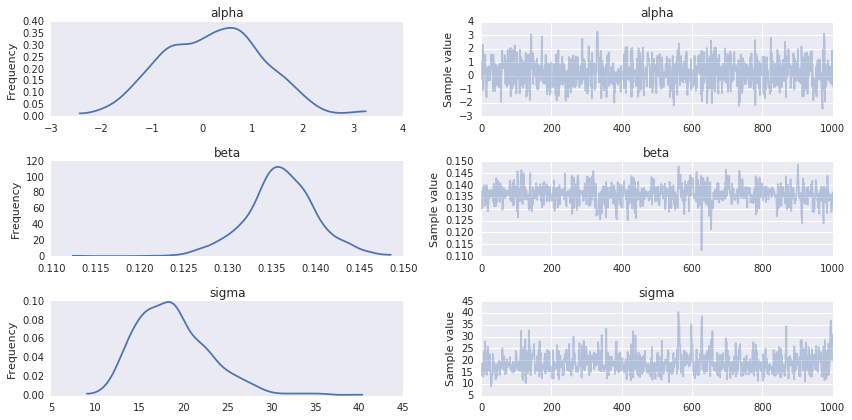

In [11]:
sns.set_style('darkgrid')
pm.traceplot(trace[-1000:], ['alpha', 'beta', 'sigma'])
plt.show()

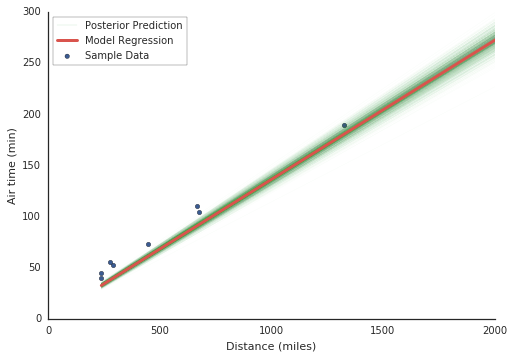

In [12]:
n_samples = 1000

x = local.Distance.values
y = local.AirTime.values

sns.set_style('white')

fig, ax = plt.subplots()

ax.scatter(x, y, c=sns.xkcd_rgb['denim blue'], label = 'Sample Data')

xl = x.min()
xh = x.max()

intercepts = trace['alpha'][-n_samples:]
slopes = trace['beta'][-n_samples:]

for m, b in zip(slopes, intercepts):
    yl = m * xl + b
    yh = m * xh + b
    ax.plot((xl, xh), (yl, yh), color=sns.xkcd_rgb['medium green'], lw=0.1, alpha = 0.1)

# Replot last one to get legend label
ax.plot((xl, xh), (yl, yh), color=sns.xkcd_rgb['medium green'], lw=0.1, label = 'Posterior Prediction')

m_fit = slopes.mean()
b_fit = intercepts.mean()

yfl = b_fit + m_fit * xl
yfh = b_fit + m_fit * xh
ax.plot((xl, xh), (yfl, yfh), color=sns.xkcd_rgb['pale red'], lw=3, label='Model Regression')

ax.set_xlim(0, 2000)
ax.set_ylim(0, 300)

ax.legend(loc='upper left', frameon=True)

ax.set_xlabel('Distance (miles)')
ax.set_ylabel('Air time (min)')

sns.despine()
plt.show()